In [1]:
import sys
sys.path.append('/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI/BasicExample')

import torch
torch.manual_seed(3)
from torch import nn, optim
import torch.nn.functional as F 
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 16,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
import matplotlib
from src.network.feature_extractor import FC_Net
from src.network.Classification import LLVIClassification
from src.network import LikApprox, PredictApprox
from datasets.Classification.circles import create_test_points
from syndata.synthetic_datasets import generate_p2

In [2]:
n_datapoints=256
batch_size = 32
class_datapoints = int(n_datapoints/2)
x,y = generate_p2([class_datapoints]*2)
x = torch.tensor(x).float()
y = torch.tensor(y).long()
train_loader = DataLoader(TensorDataset(x, y), batch_size=batch_size)

In [3]:
lr = 1e-3
feature_extractor = FC_Net(layers=[2, 20, 20],lr=lr, weight_decay=5e-4, optimizer=torch.optim.Adam, nll=torch.nn.LeakyReLU())

from src.weight_distribution.Diagonal import Diagonal
from src.weight_distribution.Full import FullCovariance
dist = Diagonal(20, 2, lr=lr)

net = LLVIClassification(20, 2, feature_extractor, dist,
prior_log_var=-5, optimizer_type=torch.optim.Adam,
tau=1, lr=lr)
net.train_without_VI(train_loader, epochs=5000)
pred_test = torch.argmax(net.forward_ML(x), dim=-1)
print("accuracy", torch.mean((pred_test == y).float()).item())

prediction_loss:0.27: 100%|██████████| 5000/5000 [00:28<00:00, 173.83it/s]


accuracy 0.90234375


In [8]:
lr = 1e-3
feature_extractor_vi = FC_Net(layers=[2, 20, 20],lr=lr, weight_decay=5e-4, optimizer=torch.optim.Adam, nll=torch.nn.LeakyReLU())

from src.weight_distribution.Diagonal import Diagonal
from src.weight_distribution.Full import FullCovariance
dist_vi = Diagonal(20, 2, lr=lr)

net_vi = LLVIClassification(20, 2, feature_extractor_vi, dist_vi,
prior_log_var=-1, optimizer_type=torch.optim.Adam,
tau=1, lr=lr)
net_vi.train_em_style(train_loader, n_datapoints, total_epochs=5000, inner_epochs_fe=1, inner_epochs_vi=2, method=LikApprox.MONTECARLO, samples=10)
pred_test = torch.argmax(net_vi(x, method=PredictApprox.MONTECARLO, samples=1000), dim=1)
print("accuracy", torch.mean((pred_test == y).float()).item())

FE:0.4, LogLik0.2, KL_div:0.07: 100%|██████████| 5000/5000 [00:45<00:00, 110.61it/s]  


accuracy 0.83984375


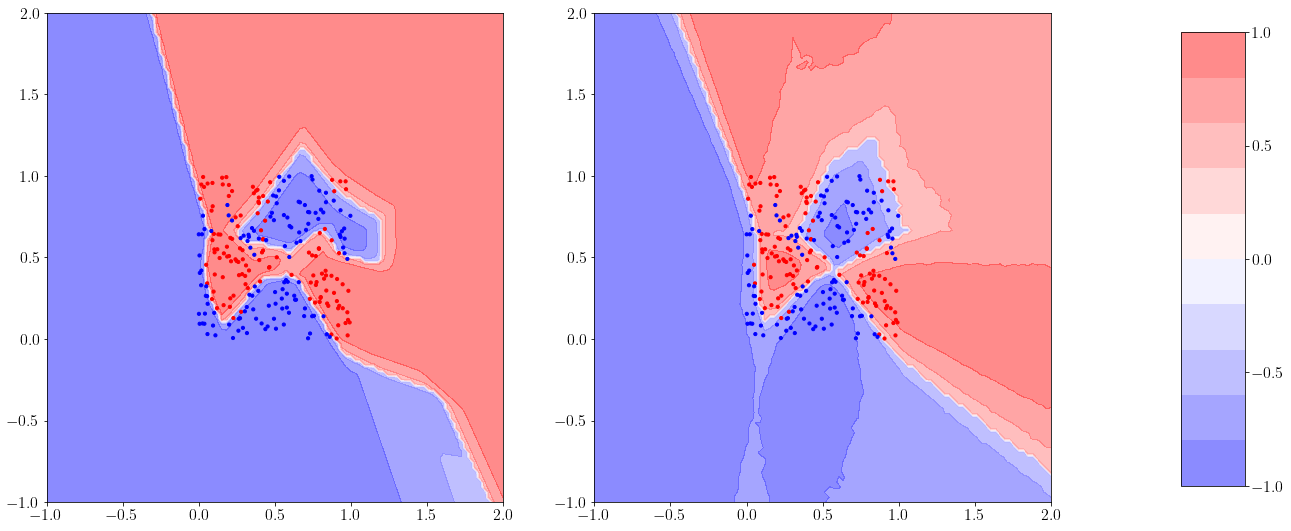

In [16]:
n_test_datapoints = 100
X_test, X1_test, X2_test = create_test_points(-1, 2, n_test_datapoints)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,9))
cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
# normal model
with torch.no_grad():
    lik = torch.softmax(net.forward_ML(X_test), dim=-1)

pred = torch.argmax(lik, dim=1)
lik[:,1] *=-1
map_conf = lik[torch.arange(lik.shape[0]), pred].reshape(n_test_datapoints, n_test_datapoints)
cax1 = ax1.contourf(X1_test, X2_test, map_conf, cmap="bwr", alpha=0.5, levels=10)
ax1.scatter(x[:, 0], x[:, 1], c=y, cmap=matplotlib.colors.ListedColormap(["red", "blue"]), s=10)

# VI model
with torch.no_grad():
    lik_vi = net_vi(X_test, method = PredictApprox.MONTECARLO, samples=5000)

ax2.clear()
# map_conf_vi = lik_vi.max(1).values.reshape(n_test_datapoints, n_test_datapoints)
pred_vi = torch.argmax(lik_vi, dim=1)
lik_vi[:,1] *=-1
map_conf_vi = lik_vi[torch.arange(lik_vi.shape[0]), pred_vi].reshape(n_test_datapoints, n_test_datapoints)
cax2 = ax2.contourf(X1_test, X2_test, map_conf_vi, cmap="bwr", alpha=0.5, levels=10)
cbar = fig.colorbar(cax2, cbar_ax, ticks=[-1, -0.5, 0, 0.5, 1])
ax2.scatter(x[:, 0], x[:, 1], c=y, cmap=matplotlib.colors.ListedColormap(["red", "blue"]), s=10)
